# RV-Only Fit Example: TOI-2379 b
* This notebook is a tutorial for 2 instrument RV-Only fit.

## Importing ExoMUSE and required libraries

In [108]:
#We first use %matplotlib inline to display the plots in the notebook.
%matplotlib inline

In [109]:
#We then import the required libraries.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

import corner
import radvel

import os
import sys
import astropy.time

In [110]:
#We then import the ExoMUSE codes.
sys.path.insert(0, '../../ExoMUSE/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import ExoMUSE_fit.py, ExoMUSE_utils.py, and ExoMUSE_gaiasource.py as standards.
import ExoMUSE_fit
import ExoMUSE_utils
import ExoMUSE_gaiasource

reload(ExoMUSE_fit)

ExoMUSE_fit, ExoMUSE_utils, ExoMUSE_gaiasource

list.remove(x): x not in list


(<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_fit.py'>,
 <module 'ExoMUSE_utils' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_utils.py'>,
 <module 'ExoMUSE_gaiasource' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_gaiasource.py'>)

In [111]:
#We also import rcParams to keep our plots consistent throughout various notebooks.
from matplotlib import rcParams

#We change the formating of the plots.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

## Data Input

In [112]:
#We import the datasets.
#Since this is an RV-Only Fit we import:
    #RV Data

#We read the RV dataset file.
data = pd.read_csv("../../data/rvdata/TOI-2379_RV_data.csv")

data

t        rv  rv_err instrument
0   2.459498e+06  27801.60    9.47   ESPRESSO
1   2.459501e+06  26881.81    5.37   ESPRESSO
2   2.459520e+06  27865.79    5.75   ESPRESSO
3   2.459521e+06  28547.72    3.77   ESPRESSO
4   2.459522e+06  28423.49    3.03   ESPRESSO
5   2.459528e+06  27157.53    3.16   ESPRESSO
6   2.459529e+06  26873.69    3.32   ESPRESSO
7   2.459472e+06    162.90   12.04        PFS
8   2.459472e+06     94.83   13.99        PFS
9   2.459472e+06    223.48   15.28        PFS
10  2.459476e+06   -332.64   26.50        PFS
11  2.459532e+06     -8.95   11.86        PFS
12  2.459532e+06     56.76   12.61        PFS
13  2.459532e+06      0.00   12.18        PFS
14  2.459535e+06  -1476.56   11.39        PFS
15  2.459535e+06  -1467.28   10.24        PFS
16  2.459535e+06  -1424.81   10.92        PFS

In [113]:
#Since there are RV data from 2 instruments, we take the data from the instruments separately.

#ESPRESSO RV Data
t1 = data[data['instrument'] == 'ESPRESSO']['t'].values
rv1 = data[data['instrument'] == 'ESPRESSO']['rv'].values
e_rv1 = data[data['instrument'] == 'ESPRESSO']['rv_err'].values

#PFS RV Data
t2 = data[data['instrument'] == 'PFS']['t'].values
rv2 = data[data['instrument'] == 'PFS']['rv'].values
e_rv2 = data[data['instrument'] == 'PFS']['rv_err'].values

## Setting up the Priors 

In [114]:
#We then import the Prior file for the RV-Only Fit.
f = "../../data/rvpriors/TOI2379_PriorsRV.txt"

reload(ExoMUSE_fit)

<module 'ExoMUSE_fit' from '/home/kaya/ExoMUSE/notebooks/rv-tests/../../ExoMUSE/ExoMUSE_fit.py'>

## Setting up the Log-Likelihood

In [115]:
#We then use "LPFunctionRVOnly2" for the RV-Only Fit.
    #"LPFunction" => Log-Likelihood Function
    #"RVOnly" => RV-Only Fit
    #"2"=> 2 instruments

#We setup our Log-Likelihood Function by using both the datasets and the prior file.
#Note that this function prints out the Priors.
L = ExoMUSE_fit.LPFunctionRVOnly2(t1, rv1, e_rv1, t2, rv2, e_rv2, file_priors = f)

Reading in priorfile from ../../data/rvpriors/TOI2379_PriorsRV.txt
   prior          arg1         arg2        label  description priortype  fixed
0     NP  5.469383e+00     0.000002         P_p1         P_p1     model  False
1     NP  2.459402e+06     0.000160        tp_p1        tp_p1     model  False
2     UP  0.000000e+00     0.500000       ecc_p1       ecc_p1     model  False
3     UP  0.000000e+00   360.000000     omega_p1     omega_p1     model  False
4     NP  5.263000e-02     0.000910         a_p1         a_p1     model  False
5     UP  0.000000e+00  1500.000000         K_p1         K_p1     model  False
6     NP  2.771890e+04     5.100000       gamma1       gamma1     model  False
7     NP -8.160000e+02    54.000000       gamma2       gamma2     model  False
8     UP  0.000000e+00   300.000000    sigma_rv1    sigma_rv1     model  False
9     UP  0.000000e+00   300.000000    sigma_rv2    sigma_rv2     model  False
10    FP  0.000000e+00     0.000000     gammadot     gammadot   

In [116]:
#We then define a fitting object by using the Log-Likelihood as follows.
TF = ExoMUSE_fit.ExoMUSEfitRVOnly(L)

## Setting up the MCMC run

In [117]:
#For the MCMC, we use pyDE and emcee.
#We use pyDE to find the initial points for the chains.
#We then use emcee.EnsembleSampler to run the MCMC chains.
#This is all done by .minimize_pyDE() function from ExoMUSE_Fit.
    #de_iter => Differential Evolution iterations, used for the distribution of walkers.
        #To distribute better, we increase de_iter.
        #However, this would increase the initial optimization time.
    #mc_iter => MCMC iterations, used for the number of steps in the chains.
        #We can evaluate the chains using GR Statistic and/or Autocorrelation time.
        #Depending on the evaluations, we can increase the mc_iter.
        #However, this will of course increase the time of the MCMC run.

TF.minimize_PyDE(de_iter=8000,mc_iter=10000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
      labels       centers         lower         upper            pv   center_dist
0       P_p1  5.469383e+00  5.469371e+00  5.469394e+00  5.469383e+00  5.284906e-08
1      tp_p1  2.459402e+06  2.459402e+06  2.459402e+06  2.459402e+06  5.904585e-06
2     ecc_p1  2.500000e-01  0.000000e+00  5.000000e-01  3.392912e-01 -8.929119e-02
3   omega_p1  1.800000e+02  0.000000e+00  3.600000e+02  8.262651e+01  9.737349e+01
4       a_p1  5.263000e-02  4.808000e-02  5.718000e-02  5.263695e-02 -6.952272e-06
5       K_p1  7.500000e+02  0.000000e+00  1.500000e+03  9.743310e+02 -2.243310e+02
6     gamma1  2.771890e+04  2.769340e+04  2.774440e+04  2.771842e+04  4.788443e-01
7     gamma2 -8.160000e+02 -1.086000e+03 -5.460000e+02 -7.951134e+02 -2.088656e+01
8  sigma_rv1  1.500000e+02  0.000000e+00  3.000000e+02  2.764110e+01  1.223589e+02
9  sigma_rv2  1.500000e+02  0.000000e+00  3.000000e+02  1.164469e+02  3.355306e+01
LogPost value: -100.81556

## Flattening the Chains

In [118]:
#We can define the burn-in period to be the first 1000 steps.
#This means that we will discard the first 1000 samples from each chain.
burnin_index = 1000

#We then discard the first 1000 samples from all of the chains as follows.
    #First part: We take all the chains.
    #Second part: We discard the first 1000 samples per chain.
    #Third part: We take all the parameters that were in the MCMC run.
chains_after_burnin = TF.sampler.chain[ : , burnin_index : , : ]

#We then have to reshape the chains to obtain the flatchain as follows.
    #TF.lpf => ExoMUSE_fit.LPFunctionRVOnly
    #.ps_vary => The Prior Set of the parameters that vary (from priors.py)
    #.priors => The priors of the varying parameters.
flatchain = chains_after_burnin.reshape((-1, len(TF.lpf.ps_vary.priors)))

In [119]:
#To store the posteriors from the flatchain, we can define a pandas DataFrame.
    #This time TF.lpf.ps_vary.labels takes the name of the varying parameters.
df_post = pd.DataFrame(flatchain, columns = TF.lpf.ps_vary.labels)

df_post

P_p1         tp_p1    ecc_p1   omega_p1      a_p1        K_p1  \
0       5.469382  2.459402e+06  0.337561  82.246875  0.053039  954.016133   
1       5.469382  2.459402e+06  0.337561  82.246875  0.053039  954.016133   
2       5.469382  2.459402e+06  0.338412  82.387914  0.052993  956.358324   
3       5.469382  2.459402e+06  0.338412  82.387914  0.052993  956.358324   
4       5.469382  2.459402e+06  0.338412  82.387914  0.052993  956.358324   
...          ...           ...       ...        ...       ...         ...   
899995  5.469383  2.459402e+06  0.332537  82.444810  0.052647  990.595285   
899996  5.469383  2.459402e+06  0.332537  82.444810  0.052647  990.595285   
899997  5.469383  2.459402e+06  0.332537  82.444810  0.052647  990.595285   
899998  5.469383  2.459402e+06  0.332537  82.444810  0.052647  990.595285   
899999  5.469383  2.459402e+06  0.332537  82.444810  0.052647  990.595285   

              gamma1      gamma2  sigma_rv1   sigma_rv2  
0       27730.526916 -742.819841  34.392652  105.459728  
1       27730.526916 -742.819841  34.392652  105.459728  
2       27730.315213 -748.298115  34.613689  109.023592  
3       27730.315213 -748.298115  34.613689  109.023592  
4       27730.315213 -748.298115  34.613689  109.023592  
...              ...         ...        ...         ...  
899995  27718.030333 -811.145172  26.243677  134.196317  
899996  27718.030333 -811.145172  26.243677  134.196317  
899997  27718.030333 -811.145172  26.243677  134.196317  
899998  27718.030333 -811.145172  26.243677  134.196317  
899999  27718.030333 -811.145172  26.243677  134.196317  

[900000 rows x 10 columns]

## Assessing the Chains

In [120]:
#To check and assess the chains, we can use mcmc_help.
import mcmc_help

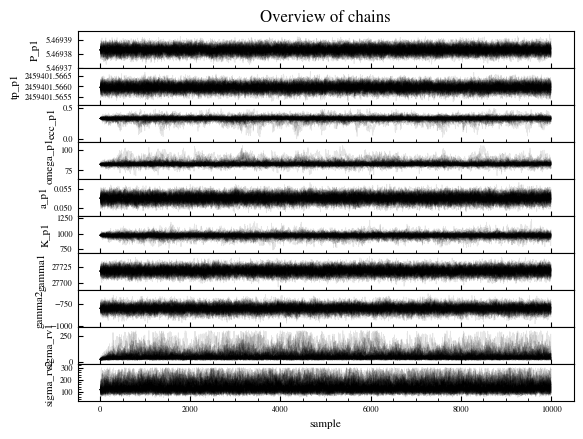

In [121]:
#We use the plot_chains function from the mcmc_help module to plot the chains.
#Note that TF.sampler is equivalent to an emcee.EnsembleSampler object.
mcmc_help.plot_chains(TF.sampler.chain, labels = TF.lpf.ps_vary.labels)

plt.show();

In [122]:
#We can also check the Gelman-Rubin (GR) Statistic to evaluate the chains of each parameter.
#We want the GR statistic to be within 1% of unity => The results should be 1 to 1.01
print("GR Statistics:")
print(50 * "-")
print(mcmc_help.gelman_rubin(chains_after_burnin))
print(50 * "-")

GR Statistics:
--------------------------------------------------
[1.00910416 1.00718935 1.00898265 1.01071861 1.0073826  1.00893276
 1.00756424 1.00726057 1.01074429 1.00862405]
--------------------------------------------------


In [123]:
#We can also check the autocorrelation time of the chains.
#If the chain isn't long enough, we would get the following error:
    #The chain is shorter than 50 times the integrated autocorrelation time for x parameter(s).
    #Use this estimate with caution and run a longer chain: N/50 = 40

try:
    print(50 * "-")
    print("Autocorrelation Time")
    print(50 * "-")
    tau = TF.sampler.get_autocorr_time()
    print(tau)

    #We can also divide the length of the chain by the autocorrelation time to get the number of s
    #independent samples.
    print(50 * "-")
    print("Number of Independent Samples")
    print(50 * "-")
    N_eff = len(flatchain) / tau
    print(N_eff)
    print(50 * "-")
    
except Exception as e:
    print("Error calculating the autocorrelation time:", e)
print(50 * "-")


--------------------------------------------------
Autocorrelation Time
--------------------------------------------------
[118.50371239 114.30976867 141.80644274 154.08990696 117.02104939
 135.88063054 118.42049738 116.18415926 173.59205284 130.63428967]
--------------------------------------------------
Number of Independent Samples
--------------------------------------------------
[7594.69878097 7873.34285111 6346.67919609 5840.74594998 7690.92402363
 6623.46058018 7600.03563503 7746.32278388 5184.56913942 6889.46219439]
--------------------------------------------------
--------------------------------------------------


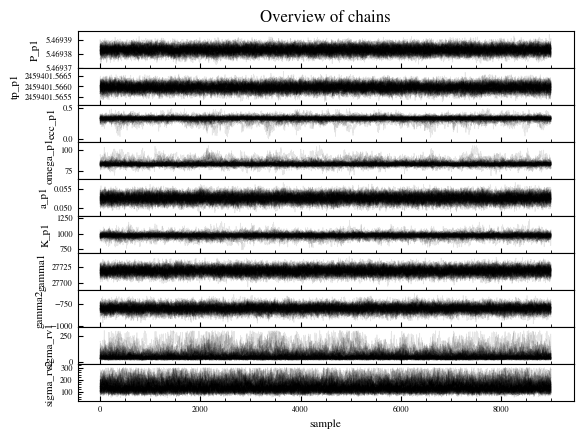

In [124]:
#We can also check how the flatchains look by plotting the flatchains.
mcmc_help.plot_chains(chains_after_burnin, labels = TF.lpf.ps_vary.labels)
plt.show();

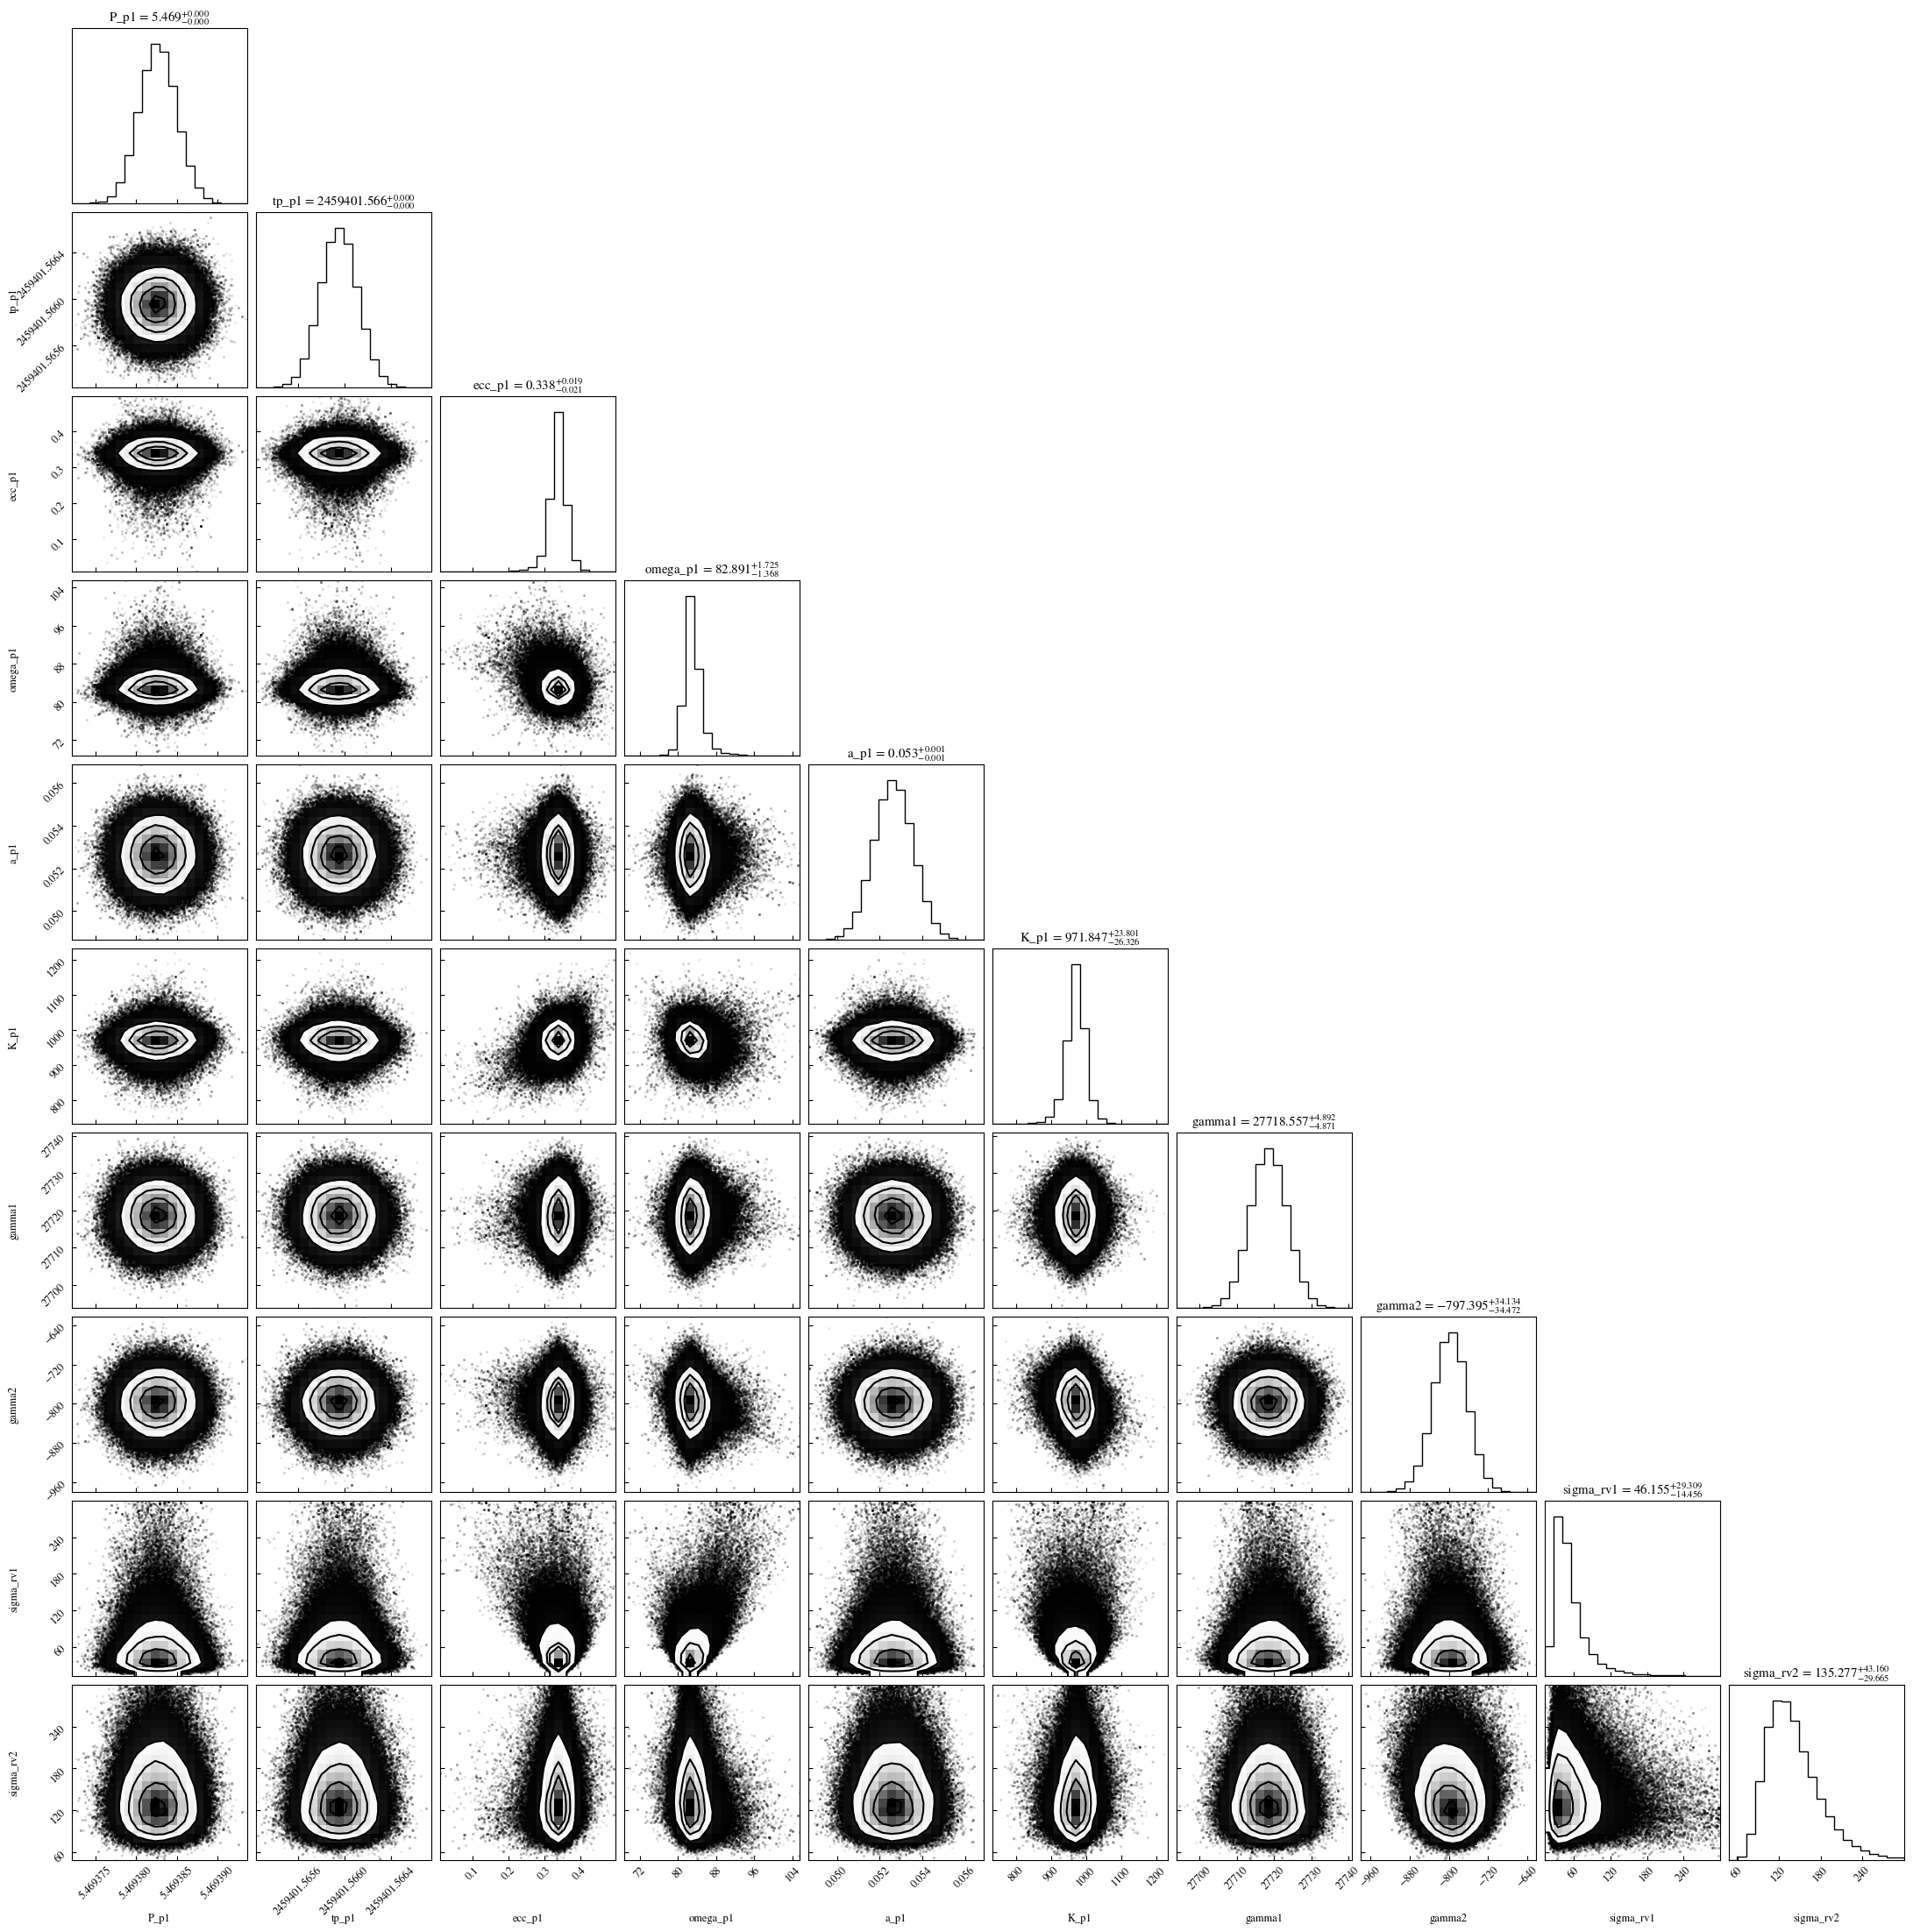

In [125]:
#We can also plot the corner plot to see the correlations and the posterior distributions
#of each parameter that was in the MCMC run.
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

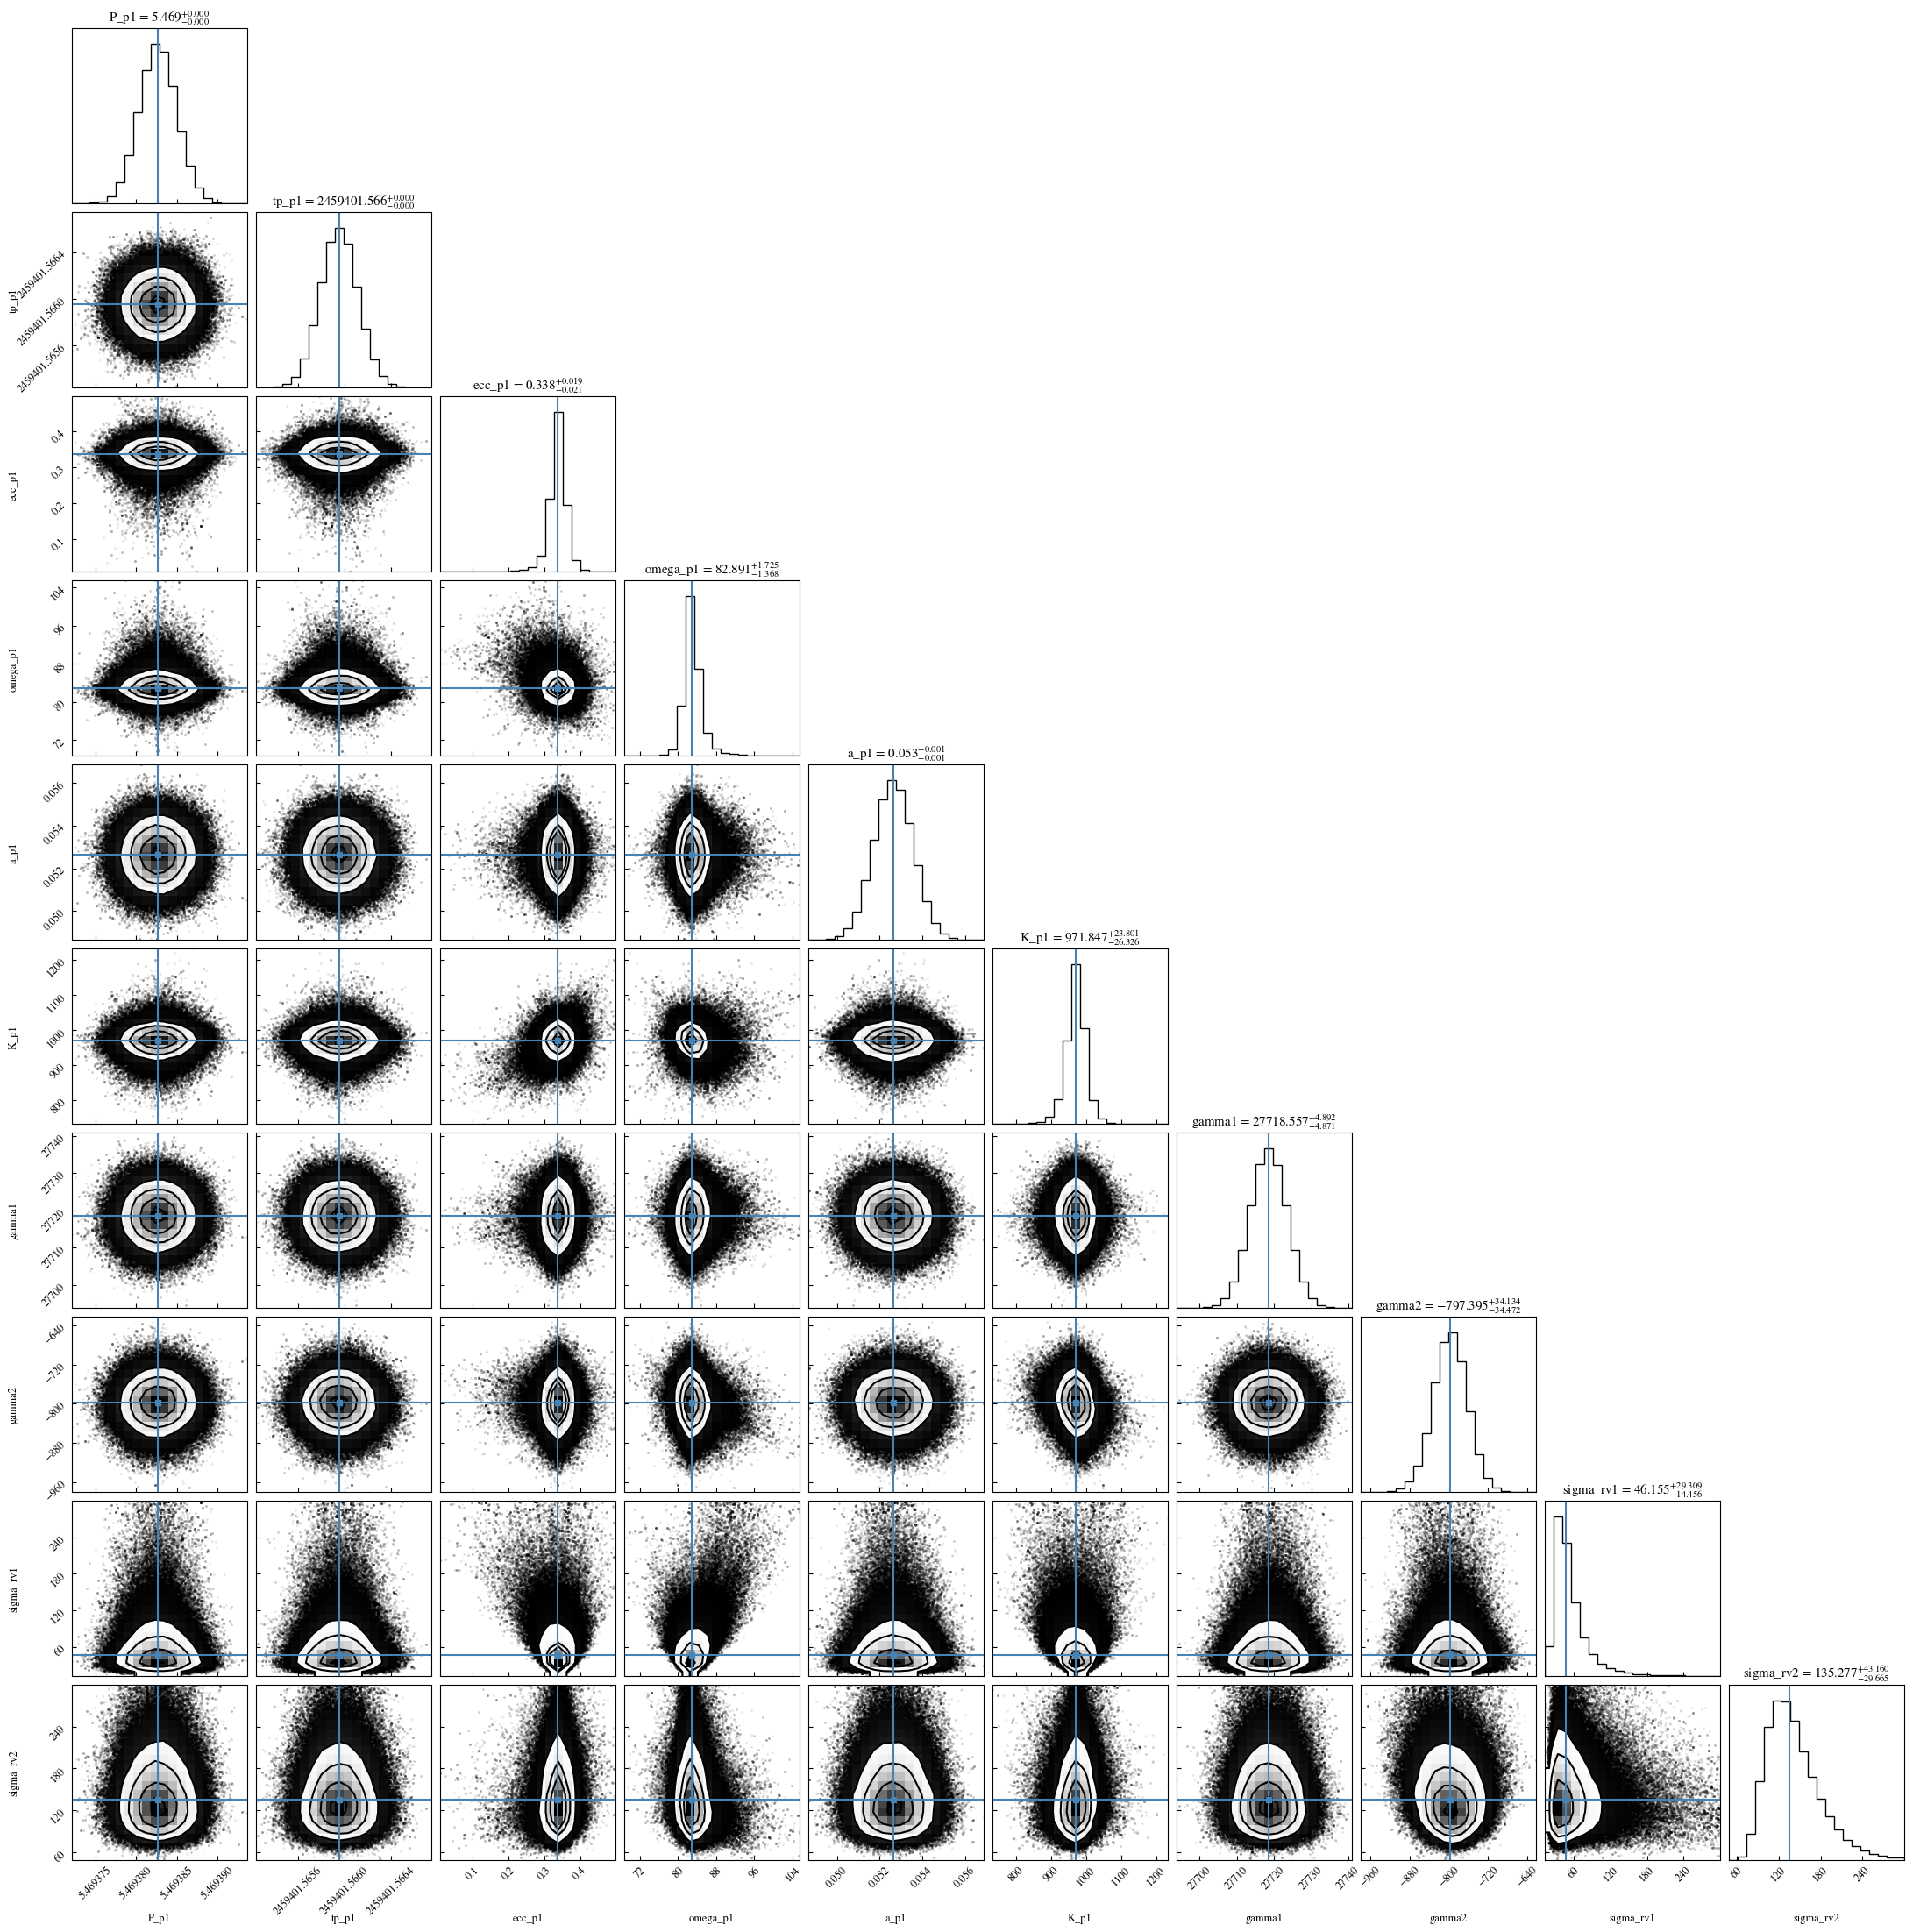

In [126]:
#We can also plot the corner plot with 50th percentile, i.e., the median to see whether
#the posterior distributions are sampled correctly or not.
#We first find the median of each parameter.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We then plot the corner plot and the median.
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

## Working with the Posteriors

In [127]:
#We can obtain the median and uncertainties of each parameter by using the
#.get_mean_values_mcmc_posteriors() function from ExoMUSE_fit.LPFunctionRVOnly.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)

df_medvals

medvals      minus       plus                                 values  \
0  5.469383e+00   0.000002   0.000002    $5.4693827_{-0.000002}^{+0.000002}$   
0  2.459402e+06   0.000159   0.000159  $2459401.56595_{-0.00016}^{+0.00016}$   
0  3.383924e-01   0.020929   0.019345              $0.338_{-0.021}^{+0.019}$   
0  8.289094e+01   1.367970   1.724639                   $82.9_{-1.4}^{+1.7}$   
0  5.263734e-02   0.000911   0.000914        $0.05264_{-0.00091}^{+0.00091}$   
0  9.718465e+02  26.326362  23.801466                $972.0_{-26.0}^{+24.0}$   
0  2.771856e+04   4.871139   4.891705                $27718.6_{-4.9}^{+4.9}$   
0 -7.973954e+02  34.472456  34.134207               $-797.0_{-34.0}^{+34.0}$   
0  4.615459e+01  14.456033  29.308924                 $46.0_{-14.0}^{+29.0}$   
0  1.352773e+02  29.665188  43.159721                $135.0_{-30.0}^{+43.0}$   

      Labels Description  
0       P_p1        P_p1  
0      tp_p1       tp_p1  
0     ecc_p1      ecc_p1  
0   omega_p1    omega_p1  
0       a_p1        a_p1  
0       K_p1        K_p1  
0     gamma1      gamma1  
0     gamma2      gamma2  
0  sigma_rv1   sigma_rv1  
0  sigma_rv2   sigma_rv2

In [128]:
df_medvals[["Labels", "values"]]

Labels                                 values
0       P_p1    $5.4693827_{-0.000002}^{+0.000002}$
0      tp_p1  $2459401.56595_{-0.00016}^{+0.00016}$
0     ecc_p1              $0.338_{-0.021}^{+0.019}$
0   omega_p1                   $82.9_{-1.4}^{+1.7}$
0       a_p1        $0.05264_{-0.00091}^{+0.00091}$
0       K_p1                $972.0_{-26.0}^{+24.0}$
0     gamma1                $27718.6_{-4.9}^{+4.9}$
0     gamma2               $-797.0_{-34.0}^{+34.0}$
0  sigma_rv1                 $46.0_{-14.0}^{+29.0}$
0  sigma_rv2                $135.0_{-30.0}^{+43.0}$

In [129]:
#We can also calculate other parameters, such as the Mass of the Planet.
#To do this we can use ExoMUSE_utils function msini_from_rvs.
#The function is defined as msini_from_rvs(K, M_star, P, e, i):
    #K => Semi-Amplitude in m/s
    #M_star => Stellar Mass in Solar Masses.
    #P => Period in days.
    #e => Eccentricity.
    #i => Inclination in degrees.
#Note that ExoMUSE_utils.msini_from_rvs() function returns the mass in Jupiter Masses.

#In our case, since we do not have the stellar mass we can get it from external sources.
#We assume i = 90 degrees to find the minimum mass of the planet.
df_post["mp"] = ExoMUSE_utils.msini_from_rvs(df_post["K_p1"].values,
                                             np.random.normal(0.645,0.033,flatchain.shape[0]),
                                             df_post["P_p1"].values,
                                             df_post["ecc_p1"].values,
                                             i = 90)

#We can then use get_vals from ExoMUSE_utils to get the median and uncertainties of the mass.
#Since the returned masses are in Jupiter masses and 1 M_jupiter = 317.828 M_earth, we can
#multiply the returned mass chain by 317.828 to convert it to Earth masses.
mp = ExoMUSE_utils.get_vals(df_post["mp"].values * 317.828, print_result = True, param_name = "Mplanet")

#We can also print the mass of the planet by using the outputs from get_vals:
    #First output: Median value
    #Second output: Lower uncertainty
    #Third output: Upper uncertainty
print(f"Mass of the Planet: {mp[0]}, +{mp[2]} -{mp[1]} M_Earth")

Mplanet: 1878.468214 +82.992737 -83.469521
Mass of the Planet: 1878.4682139568722, +82.99273653489718 -83.46952052104461 M_Earth


## Plotting the Data and the Best-Fit Model

In [130]:
#We first define the Title and the amount of times we will sample the model.
TITLE = "TOI-2379 RV-Only Fit"
NUM_SAMPLES = 5000

### Plotting the Data and the Best-Fit Model over Time

In [131]:
#We can first plot the data and the best-fit model over time.
    #Optional: If there we want to convert Julian Dates into Datetimes, i.e. DD-MM-YYYY format,
    #we can use ExoMUSE_utils.jd2datetime(times) function, where times is in Julian Dates.

#For this, we first get the times from our dataset.
times_data1 = TF.lpf.data["x1"]
times_data2 = TF.lpf.data["x2"]

print(times_data1)
print(times_data2)

[2459497.60994212 2459500.61738876 2459519.61671364 2459520.58923126
 2459521.63005011 2459527.68871351 2459528.59646265]
[2459471.72689 2459471.74115 2459471.75665 2459475.72037 2459531.64196
 2459531.65633 2459531.67043 2459534.55251 2459534.5671  2459534.58025]


In [132]:
#We first get the medians of the parameters by using the flatchain.
#This again can be obtained by checking the 50th percentile of the flatchains.
pv_50 = np.percentile(flatchain, [50], axis=0)[0]

#We then define the amount of times where we will sample the Best-Fit Model.
times_model = np.linspace(times_data1.min()-30, times_data2.max()+10, NUM_SAMPLES)

#We then compute the best-fit model by using the median values and defined times.
rv_model1, rv_model2 = TF.lpf.compute_total_model(pv_50, times_model, times_model)

#We also compute the radial velocity data from the model at the observation times.
rv_data_from_model1, rv_data_from_model2 = TF.lpf.compute_total_model(pv_50, times_data1, times_data2)

#From here, we can calculate the residuals, i.e., DATA - MODEL
residuals1 = TF.lpf.data["y1"] - rv_data_from_model1
residuals2 = TF.lpf.data["y2"] - rv_data_from_model2

In [133]:
#We can also plot the uncertainty intervals of our model.
#For this, we can define the following loop that does:
    #1-) Sample a random vector of parameters from the flatchain. E.g. 200th chain
    #2-) Compute the RV curve using the sampled parameter set/vector.
    #3-) Add this RV curve model to a list.
    #4-) Sample from this list to get the uncertainty intervals.

#For this we first define a list to store all of the RV models.
rv_models_for_uncertainty = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model1, model2 = TF.lpf.compute_total_model(flatchain[idx], times1 = times_model)
    rv_models_for_uncertainty.append(model1)

#We then convert this list to an array.
rv_models_for_uncertainty = np.array(rv_models_for_uncertainty)

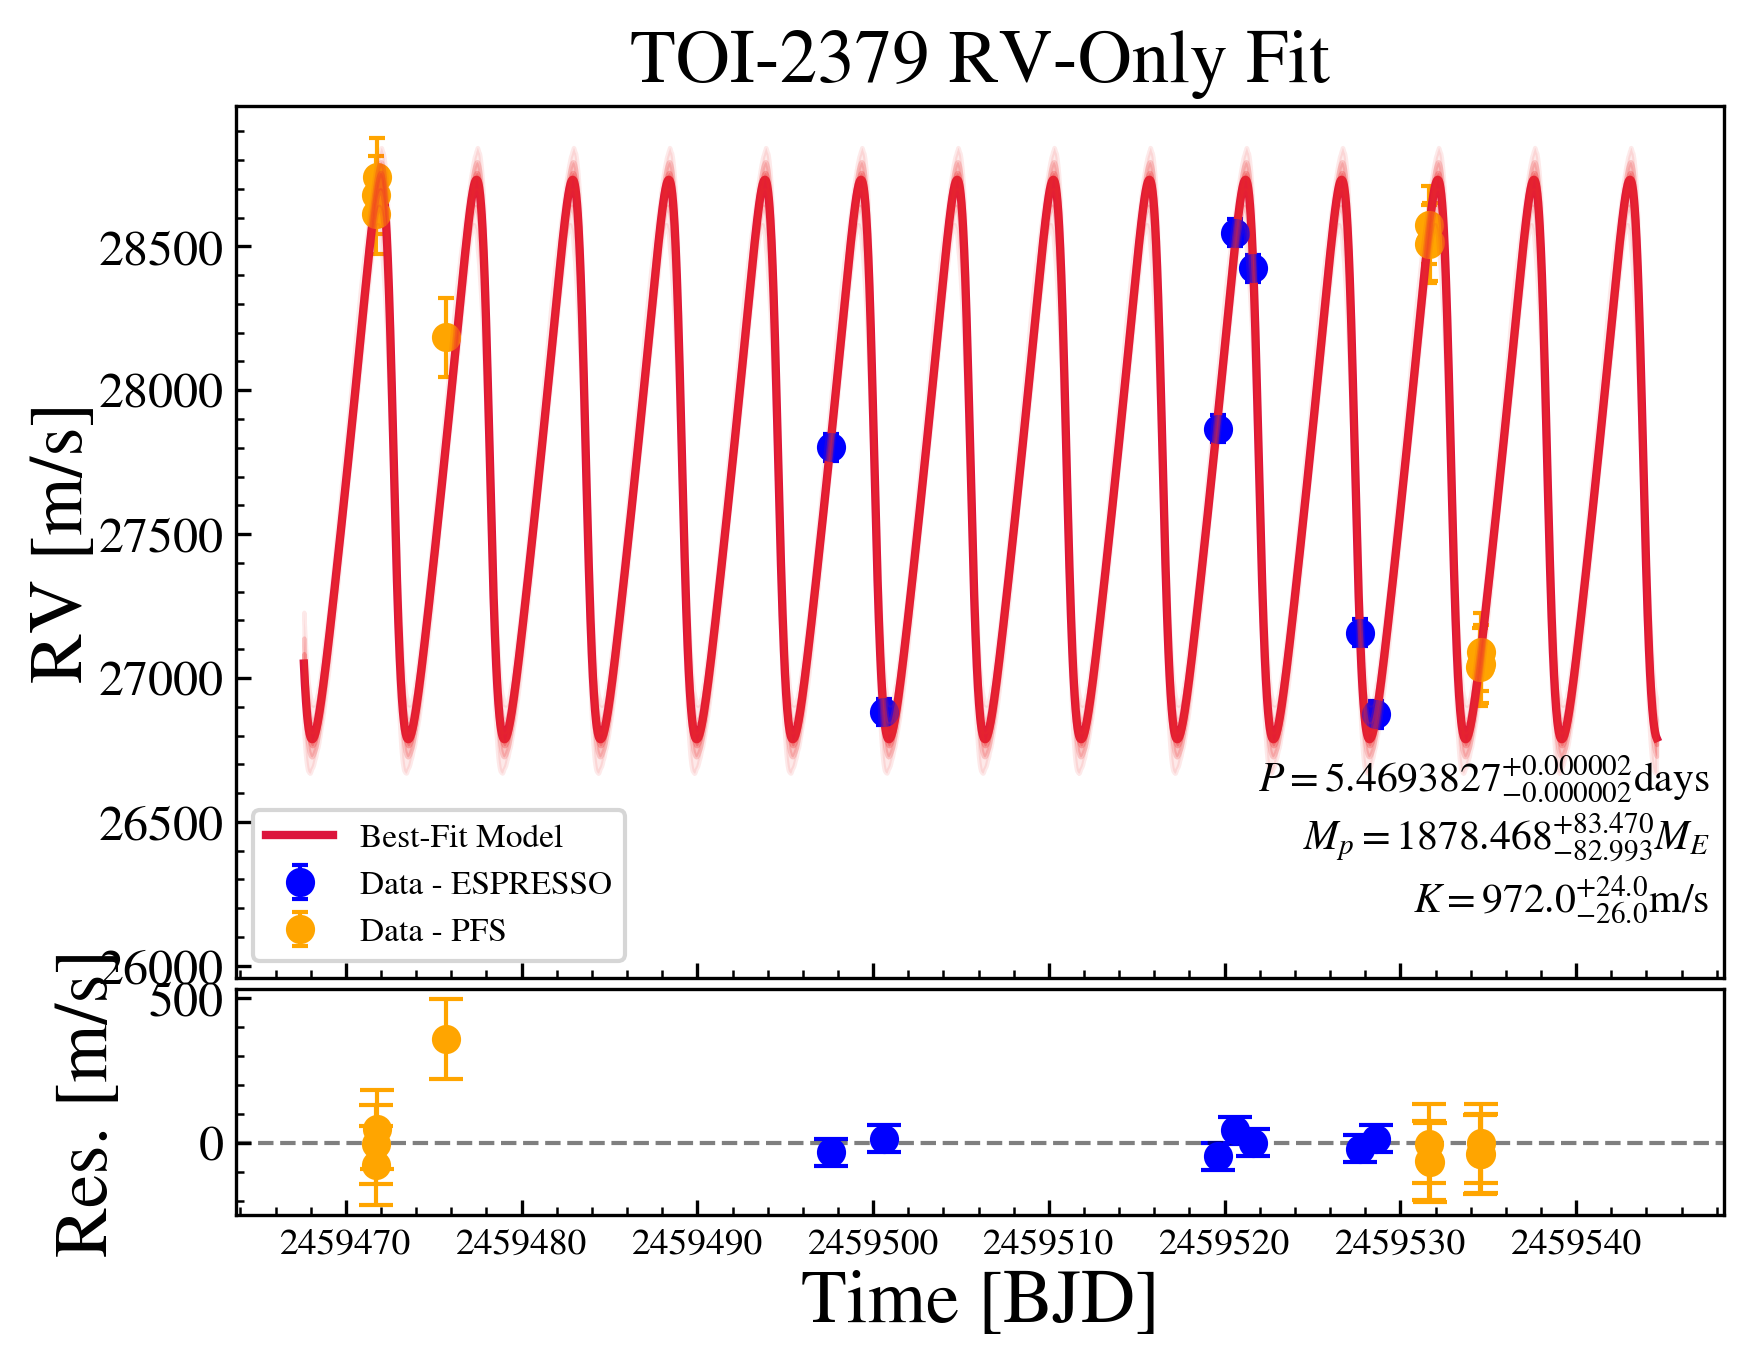

In [134]:
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"
label_params += "$M_p=${}$M_E$".format(f"${mp[0]:.3f}_{{-{mp[2]:.3f}}}^{{+{mp[1]:.3f}}}$")+"\n"
label_params += "$K=${}".format(df_medvals[df_medvals.Labels=="K_p1"]["values"].values[0])+"m/s\n"

#We can also add the model of RV uncertainties into the datapoints.
uncertainty_sigma1 = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv1"].values[0]
uncertainty_sigma2 = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv2"].values[0]

#In this fit, we kept the uncertainties free.
inflated_rv_err1 = np.sqrt(pow(TF.lpf.data["error1"], 2) + pow(uncertainty_sigma1, 2))
inflated_rv_err2 = np.sqrt(pow(TF.lpf.data["error2"], 2) + pow(uncertainty_sigma2, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(TF.lpf.data["x1"], TF.lpf.data["y1"], yerr = inflated_rv_err1,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - ESPRESSO', zorder = -10)

#Note that since the times and the model is defined from the first instrument, we need to use the 
#systematic velocity values to normalize the dataset from the second instrument.
ax.errorbar(TF.lpf.data["x2"],
            TF.lpf.data["y2"]-TF.lpf.get_jump_parameter_value(pv_50,'gamma2')+TF.lpf.get_jump_parameter_value(pv_50,'gamma1'),
            yerr = inflated_rv_err2,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="orange",
            markersize=6, label='Data - PFS', zorder = -10)

#We also plot our best-fit model.
ax.plot(times_model, rv_model1, color="crimson", label = "Best-Fit Model", lw=2., zorder=-10)

#We then plot the residuals.
bx.errorbar(TF.lpf.data["x1"], residuals1, yerr = inflated_rv_err1,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)
bx.errorbar(TF.lpf.data["x2"], residuals2, yerr = inflated_rv_err2,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="orange",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using rv_models_for_uncertainty.
#1 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 16, axis=0),
                np.percentile(rv_models_for_uncertainty, 84, axis=0),
                color='#EE2C2C', alpha=0.3)
#2 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 2, axis=0),
                np.percentile(rv_models_for_uncertainty, 98, axis=0),
                color='#EE2C2C', alpha=0.2)
#3 Sigma Interval
ax.fill_between(times_model, 
                np.percentile(rv_models_for_uncertainty, 0.15, axis=0),
                np.percentile(rv_models_for_uncertainty, 99.85, axis=0),
                color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)
bx.set_xlabel('Time [BJD]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-600, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();

### Plotting the Data and the Best-Fit Model over Phase

In [135]:
#To plot the Data and the Best-Fit model over Phase, we first need to get the Period and T0
#from the flatchains.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "tp_p1"].values[0]

#We can then use ExoMUSE_utils.time_to_phase(times, P, T0) function to convert the times
#to phase.
phase_data1 = ExoMUSE_utils.time_to_phase(times_data1, P, T_0)
phase_data2 = ExoMUSE_utils.time_to_phase(times_data2, P, T_0)

#We then convert the model times to phase too.
phase_model = ExoMUSE_utils.time_to_phase(times_model, P, T_0)

#We then have to sort the data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_model_sorted = rv_model1[sorted_indices]

In [136]:
#We can again the uncertainty intervals of our model.
#It is the same structure as before.

#For this we first define a list to store all of the RV models.
rv_models_for_uncertainty_phase = []

#We then define the loop that does what we described above.
for i in range(NUM_SAMPLES):
    idx = np.random.randint(0, flatchain.shape[0])
    model1, model2 = TF.lpf.compute_total_model(flatchain[idx], times1 = times_model)
    model_sorted = model1[sorted_indices]
    rv_models_for_uncertainty_phase.append(model_sorted)

#We then convert this list to an array.
rv_models_for_uncertainty_phase = np.array(rv_models_for_uncertainty_phase)

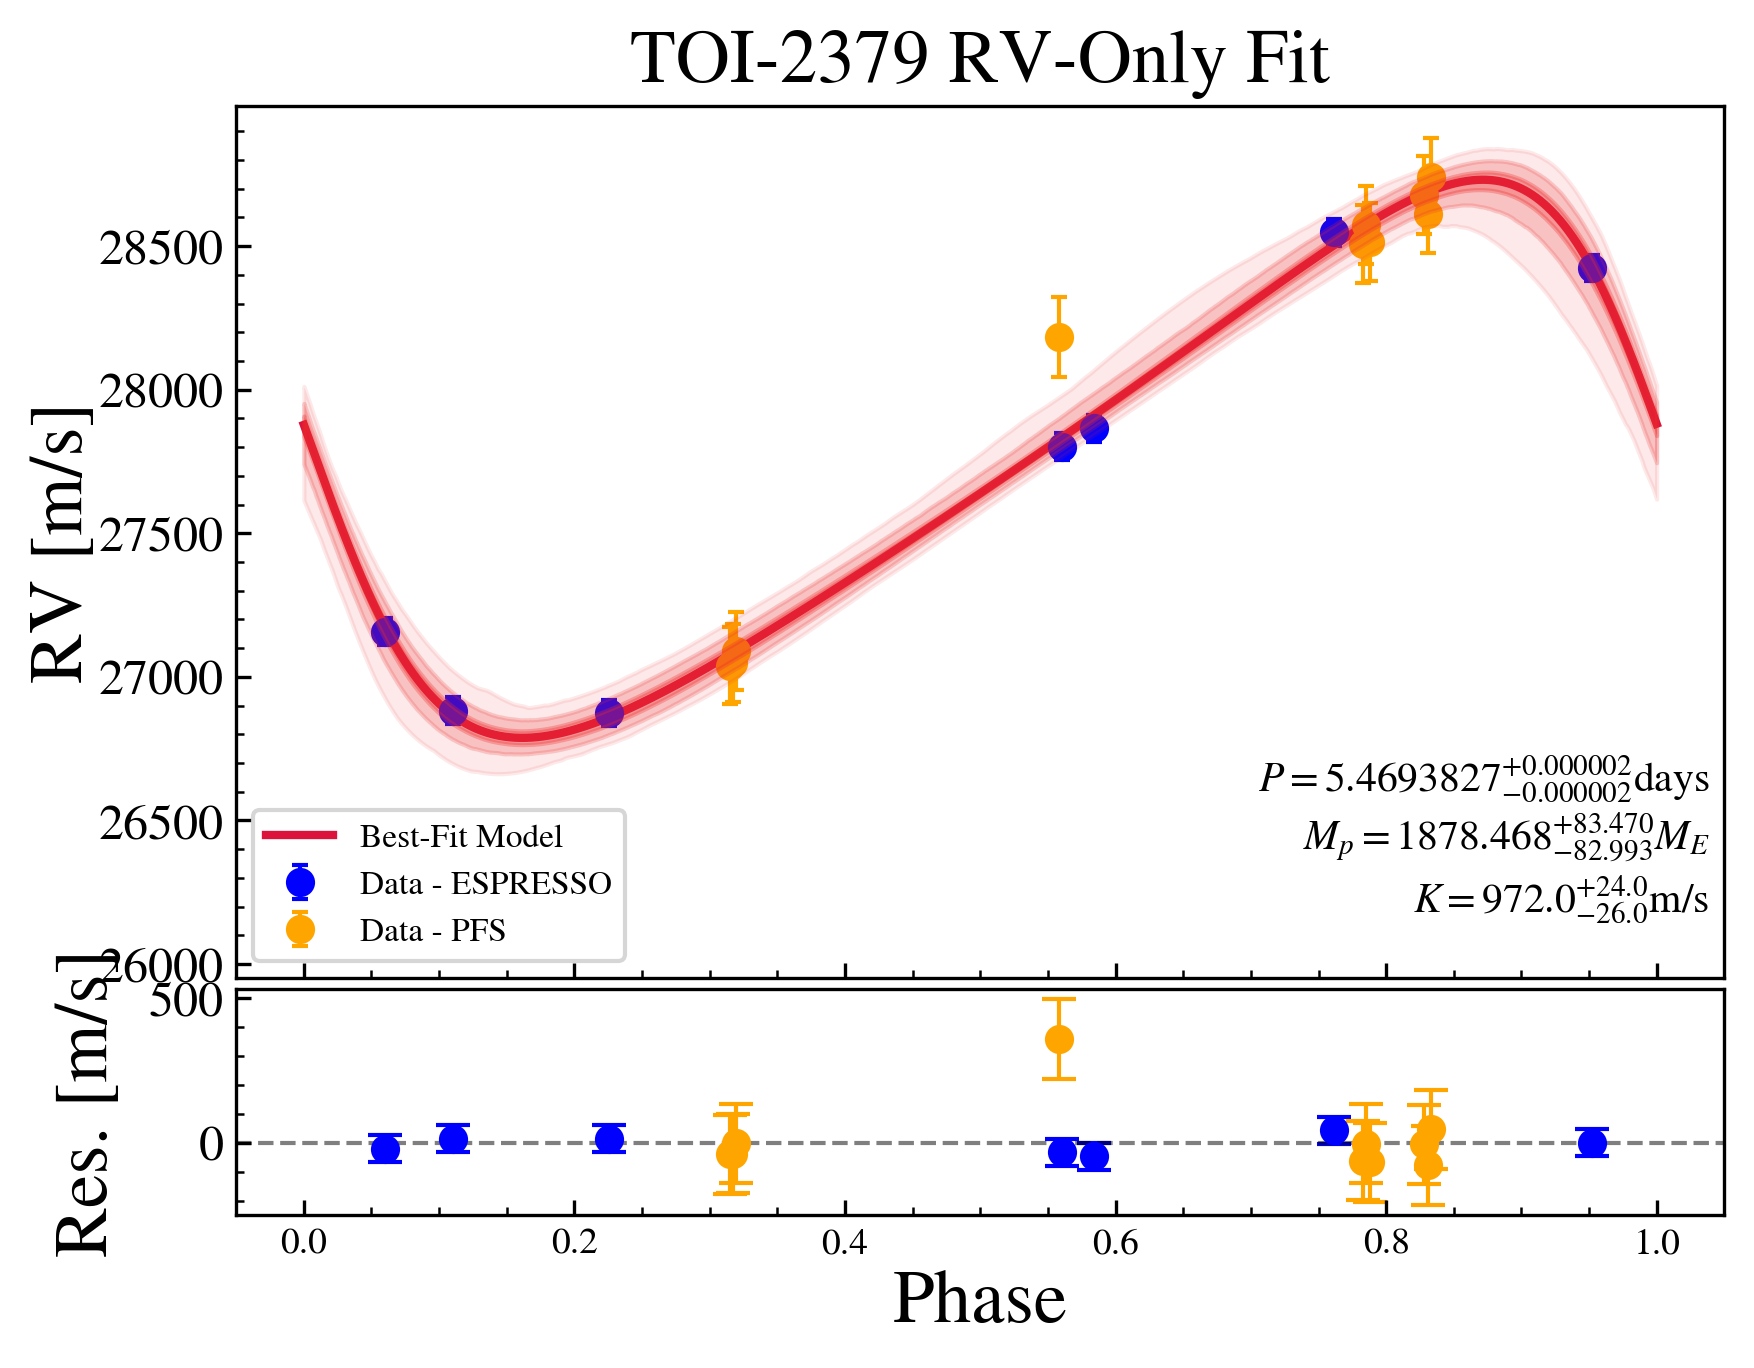

In [137]:
#We can then again plot the data as follows.
#We then plot our data.
#For this we define 2 rows with one of them for the RV and Best-Fit model, other for the residuals.
fig, (ax, bx) = plt.subplots(dpi = 300, nrows = 2, gridspec_kw = {"height_ratios": [5, 1.3]}, sharex = True)

#Optional: We can also put some of the parameter values onto our plots.
#For this, we can do the following.
label_params = "$P=${}".format(df_medvals[df_medvals.Labels=="P_p1"]["values"].values[0])+"days\n"
label_params += "$M_p=${}$M_E$".format(f"${mp[0]:.3f}_{{-{mp[2]:.3f}}}^{{+{mp[1]:.3f}}}$")+"\n"
label_params += "$K=${}".format(df_medvals[df_medvals.Labels=="K_p1"]["values"].values[0])+"m/s\n"

#We can also add the model of RV uncertainties into the datapoints.
uncertainty_sigma1 = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv1"].values[0]
uncertainty_sigma2 = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv2"].values[0]

#In this fit, we kept the uncertainties free.
inflated_rv_err1 = np.sqrt(pow(TF.lpf.data["error1"], 2) + pow(uncertainty_sigma1, 2))
inflated_rv_err2 = np.sqrt(pow(TF.lpf.data["error2"], 2) + pow(uncertainty_sigma2, 2))

#We define errorbars and the datapoints.
    #Optional: If needed, times can be put into ExoMUSE_utils.jd2datetime(times) during plotting
    #for the plot to be in DateTime format.
ax.errorbar(phase_data1, TF.lpf.data["y1"], yerr = inflated_rv_err1,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="blue",
            markersize=6, label='Data - ESPRESSO', zorder = -10)
ax.errorbar(phase_data2, 
            TF.lpf.data["y2"]-TF.lpf.get_jump_parameter_value(pv_50,'gamma2')+TF.lpf.get_jump_parameter_value(pv_50,'gamma1'),
            yerr = inflated_rv_err2,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color="orange",
            markersize=6, label='Data - PFS', zorder = -10)

#We also plot our best-fit model.
ax.plot(phase_model_sorted, rv_model_sorted, color="crimson", label = "Best-Fit Model", lw=2., zorder=-10)

#We then plot the residuals.
bx.errorbar(phase_data1, residuals1, yerr = inflated_rv_err1,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="blue",
            markersize=6, zorder = -10)
bx.errorbar(phase_data2, residuals2, yerr = inflated_rv_err2,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color="orange",
            markersize=6, zorder = -10)

#Optional: We add the parameter values onto the bottom-right of the RV graph (first row).
ax.text(0.99, 0.01, label_params, va = 'bottom', ha = 'right', fontsize=10, transform=ax.transAxes)

#We plot the uncertainty intervals by using rv_models_for_uncertainty_phase.
#1 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 16, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 84, axis=0),
                color='#EE2C2C', alpha=0.3)
#2 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 2, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 98, axis=0),
                color='#EE2C2C', alpha=0.2)
#3 Sigma Interval
ax.fill_between(phase_model_sorted, 
                np.percentile(rv_models_for_uncertainty_phase, 0.15, axis=0),
                np.percentile(rv_models_for_uncertainty_phase, 99.85, axis=0),
                color='#EE2C2C', alpha=0.1)

#We then set the labels and titles for the plot.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We get the x limit and then set a new limit.
xlim = ax.get_xlim()
ax.set_xlim(xlim[0],xlim[1])

#We do the same for y limit.
ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-600, ylim[-1]+0)

#We define additional times to plot the zero-line for residuals.
time_res = np.linspace(xlim[0],xlim[-1],100)
bx.plot(time_res,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We set 0.02 horizontal space between 2 rows of plots.
fig.subplots_adjust(hspace=0.02)

#We apply the settings to the axes.
for xx in [ax,bx]:
    ExoMUSE_utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis = 'x', labelsize = 9)
ax.set_title(TITLE, fontsize = 18)
ax.legend(loc = "lower left", fontsize = 8)

plt.show();